### Imports

In [10]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
from scipy import stats as scistats
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [6]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [15]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}
exp_time = {}
signal = []
pdtot = []

i = 1
for visit1, visit2 in zip(visits[::2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    # get detector and amp
    detector = result1.exposure.getDetector()
    amp = detector[3]

    sub_im1 = result1.exposure.maskedImage[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.maskedImage[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # get integrated photodiode signal for each image
    pdtot1 = -time1*raw1.getMetadata().getScalar('MONDIODE')
    pdtot2 = -time2*raw2.getMetadata().getScalar('MONDIODE')
    
    import lsst.afw.image as afwImage 
    x0, y0 = sub_im1.getXY0()
    xorg, yorg = 200, 900  # window origin relative to XY0
    xsize, ysize = 200, 200  # window size
    x0 = x0 + xorg
    y0 = y0 + yorg
    x1 = x0 + xsize
    y1 = y0 + ysize
    stat1_im = sub_im1[x0:x1, y0:y1]
    stat2_im = sub_im2[x0:x1, y0:y1]
    
    stats = afwMath.makeStatistics(stat1_im, afwMath.MEDIAN)
    stat1 = stats.getValue(afwMath.MEDIAN)
    
    stats = afwMath.makeStatistics(stat2_im, afwMath.MEDIAN)
    stat2 = stats.getValue(afwMath.MEDIAN)
    
    print("signal={}   pdtot={}   visit={}".format(stat1, pdtot1, visit1))
    print("signal={}   pdtot={}   visit={}".format(stat2, pdtot2, visit2))
    
    signal.append(stat1)
    signal.append(stat2)
    pdtot.append(pdtot1)
    pdtot.append(pdtot2)

    

signal=90.76335144042969   pdtot=0.01710784290144993   visit=258339739
signal=91.48408508300781   pdtot=0.0027507738060010166   visit=258339769
signal=179.12879943847656   pdtot=0.9171503118199329   visit=258339875
signal=180.37820434570312   pdtot=0.013708184633193114   visit=258339908
signal=327.2234191894531   pdtot=4.208405222815219   visit=258340014
signal=327.16082763671875   pdtot=4.231452371476741   visit=258340047
signal=772.9136962890625   pdtot=10.030393653655276   visit=258340159
signal=768.8203430175781   pdtot=9.951000152976786   visit=258340176
signal=1362.2302856445312   pdtot=17.597584922674983   visit=258340244
signal=1348.1442260742188   pdtot=17.382056212293353   visit=258340265
signal=2414.52197265625   pdtot=31.06452741493596   visit=258340341
signal=2486.7354736328125   pdtot=32.08284747263574   visit=258340363
signal=4405.214111328125   pdtot=56.658833149890064   visit=258340449
signal=4402.86328125   pdtot=56.6402721346066   visit=258340477
signal=7907.71826171

slope=77.6627657719558, intercept=9.453012543694058, rval=0.9999950599402535, pval=1.4728875343933758e-56, stdev=0.0520456240230089


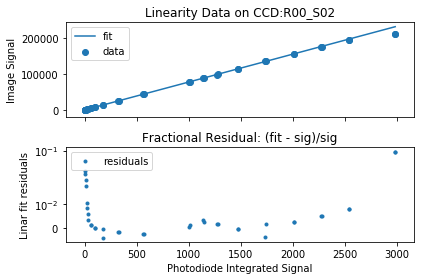

In [44]:
# set up axes
fig, axes = plt.subplots(2, 1, sharex=True)
# do a linear fit to the data first cutting on value to limit on low and high end
pdarr = numpy.array(pdtot)
sigarr = numpy.array(signal)
limit_low = 1000
limit_high = 150000
slope, intercept, rval, pval, stdev = scistats.linregress(
    pdarr[(limit_low < sigarr) & (sigarr < limit_high)],
    sigarr[(limit_low <  sigarr) & (sigarr < limit_high)])

print("slope={}, intercept={}, rval={}, pval={}, stdev={}".format(
      slope, intercept, rval, pval, stdev))

# make points to plot for the line
fitarr = pdarr * slope + intercept
axes[0].plot(pdarr, fitarr, label='fit')
axes[0].scatter(pdarr, sigarr, label="data")
# axes[0].set_xlabel('Photodiode Integrated Signal')
axes[0].set_ylabel('Image Signal')
axes[0].set_title("Linearity Data on CCD:{}".format(detector.getName()))
axes[0].legend(loc='best')

# now plot residuals
resarr = (fitarr - sigarr) / sigarr
axes[1].plot(pdarr[pdarr > 4], resarr[pdarr > 4], '.', label='residuals')
axes[1].set_yscale('symlog', linthreshy=0.02)
axes[1].set_xlabel('Photodiode Integrated Signal')
axes[1].set_ylabel('Linar fit residuals')
axes[1].set_title("Fractional Residual: (fit - sig)/sig")
axes[1].legend(loc='best')
fig.tight_layout()
